# 训练神经网络

我们在上个部分构建的神经网络其实不太成熟，它还不能识别任何数字。具有非线性激活函数的神经网络就像通用函数逼近器一样。某些函数会将输入映射到输出。例如，将手写数字图像映射到类别概率。神经网络的强大之处是我们可以训练网络以逼近这个函数，基本上只要提供充足的数据和计算时间，任何函数都可以逼近。

<img src="assets/function_approx.png" width=500px>

一开始网络很朴素，不知道将输入映射到输出的函数。我们通过向网络展示实际数据样本训练网络，然后调整网络参数，使其逼近此函数。

要得出这些参数，我们需要了解网络预测真实输出的效果如何。为此，我们将计算**损失函数**（也称为成本），一种衡量预测错误的指标。例如，回归问题和二元分类问题经常使用均方损失

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

其中 $n$ 是训练样本的数量，$y_i$ 是真实标签，
$\hat{y}_i$ 是预测标签。

通过尽量减小相对于网络参数的这一损失，我们可以找到损失最低且网络能够以很高的准确率预测正确标签的配置。我们使用叫做**梯度下降法**的流程来寻找这一最低值。梯度是损失函数的斜率，指向变化最快的方向。.要以最短的时间找到最低值，我们需要沿着梯度（向下）前进。可以将这一过程看做沿着最陡的路线下山。

<img src='assets/gradient_descent.png' width=350px>

## 反向传播

对于单层网络，梯度下降法实现起来很简单。但是，对于更深、层级更多的神经网络（例如我们构建的网络），梯度下降法实现起来更复杂，以至于研究人员花费了30年才弄明白如何训练多层网络。

我们通过**反向传播**来实现，实际上是采用的微积分中的链式法则。最简单的理解方法是将两层网络转换为图形表示法。

<img src='assets/backprop_diagram.png' width=550px>

在网络的前向传递过程中，数据和运算从下到上执行。我们使输入 $x$ 经过线性转换 $L_1$，权重为 $W_1$，偏差为 $b_1$。然后，输出经过 S 型运算 $S$ 和另一个线性转换 $L_2$。最后计算损失 $\ell$。我们使用损失来衡量网络预测的成熟程度。我们的目标是通过调整权重和偏差，使损失最小化。

要用梯度下降法训练权重，我们使损失梯度在网络中反向传播。每个运算在输入和输出之间都具有某个梯度。当我们反向传播梯度时，我们用传入梯度乘以运算的梯度。从数学角度来讲，其实就是使用链式法则计算相对于权重的损失梯度。

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ell}{\partial L_2}
$$

**注意：**要充分掌握这部分内容，你需要懂一些向量微积分。

我们使用此梯度和学习速率 $\alpha$ 更新权重。 

$$
\large W^\prime_1 = W_1 - \alpha \frac{\partial \ell}{\partial W_1}
$$

设置学习速率 $\alpha$ ，让让权重更新的步长降为很小的值
，使迭代方法能达到最小值。

## 损失

我们首先看看如何用 PyTorch 计算损失。PyTorch 通过 `nn` 模块提供了损失函数，例如交叉熵损失 (`nn.CrossEntropyLoss`)。通常损失赋值给 `criterion`。正如在上一部分提到的，对于 MNIST 等分类问题，我们使用 softmax 函数预测类别概率。对于 softmax 输出，你需要使用交叉熵损失函数。要实际计算损失，首先需要定义条件，然后传入网络输出和正确标签。

来，划重点！ [`nn.CrossEntropyLoss` 的文档](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss) 里写道：

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

这就是说，我们需要将网络的原始输出（而不是 softmax 函数的输出）传入损失函数中。这个原始输出通常称为*对数*或*分数*。之所以使用对数，是因为 softmax 生成的概率通常很接近 0 或 1，但是浮点数不能准确地表示接近 0 或 1 的值（详情请参阅[此处](https://docs.python.org/3/tutorial/floatingpoint.html)）。通常建议不要对概率进行运算，我们一般使用对数概率。

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Processing...
Done!


### 注意
如果你不熟悉 `nn.Sequential` ，请先完成 Part 2 notebook。

In [2]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128), 
                      nn.ReLU(), 
                      nn.Linear(128, 64), 
                      nn.ReLU(), 
                      nn.Linear(64, 10))
# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)

# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3197)


在我看来，使用 `nn.LogSoftmax` 或 `F.log_softmax`（[文档](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)）构建具有 log-softmax 输出的模型更方便。然后我们可以通过计算指数 `torch.exp(output)` 获得实际概率。对于 log-softmax 输出，你需要使用负对数似然损失 `nn.NLLLoss`（[文档](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)）。

>**练习：**请构建一个返回 log-softmax 输出结果并使用负对数似然损失计算损失的模型。注意，对于 `nn.LogSoftmax` 和 `F.log_softmax`，你需要相应地设置 `dim` 关键字参数。`dim=0` 会计算各行的 softmax，使每列的和为 1，而 `dim=1` 会计算各列的 softmax，使每行的和为 1。思考下你希望输出是什么，并选择恰当的 `dim`。

In [3]:
# TODO: Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128), 
                      nn.ReLU(), 
                      nn.Linear(128, 64), 
                      nn.ReLU(), 
                      nn.Linear(64, 10), 
                      nn.LogSoftmax(dim=1))

# TODO: Define the loss
criterion = nn.NLLLoss()

### Run this to check your work
# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3045)


In [4]:
torch.exp(logits).sum(dim=1)

tensor([ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
         1.0000])

## Autograd 自动计算梯度

我们已经知道如何计算损失，那么如何使用损失进行反向传播呢？Torch 提供了模块 `autograd`，用于自动计算张量的梯度。我们可以使用它计算所有参数相对于损失的梯度。Autograd 的计算方式是跟踪对张量执行的运算，然后反向经过这些运算并一路计算梯度。**为了确保 PyTorch 能跟踪对张量执行的运算并计算梯度，你需要在张量上设置 `requires_grad = True`**。你可以在创建时使用 `requires_grad` 关键字或随时使用 `x.requires_grad_(True)`。

你可以使用 `torch.no_grad()` 关闭某段代码的梯度：

In [5]:
x = torch.zeros(1, requires_grad=True)
>>> with torch.no_grad():
...     y = x * 2
>>> y.requires_grad
False

False

In [6]:
x.requires_grad

True

此外，还可以使用 `torch.set_grad_enabled(True|False)` 关闭全部梯度。

我们通过 `z.backward()` 计算相对于某个变量 `z` 的梯度。这样会反向经过创建 `z` 的运算。

In [7]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 0.1574,  1.4907],
        [ 0.1937, -1.0063]])


In [8]:
y = x**2
print(y)

tensor([[ 0.0248,  2.2223],
        [ 0.0375,  1.0126]])


下面是创建 `y` 的运算，它是一个幂运算 `PowBackward0`。

In [9]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

In [10]:
with torch.no_grad():
    y = x ** 2
y.requires_grad

False

In [11]:
print(y.grad_fn)

None


autgrad 模块会跟踪这些运算，并知道如何计算每个运算的梯度。这样的话，它就能够计算一系列运算相对于任何一个张量的梯度。我们将张量 `y` 缩减为一个标量值 - 均值。

In [12]:
z = y.mean()
print(z)

tensor(0.8243)


你可以查看 `x` 和`y` 的梯度，但是现在它们是空的。

In [13]:
print(x.grad)
print(x/2)

None
tensor([[ 0.0787,  0.7454],
        [ 0.0968, -0.5032]])


要计算梯度，你需要对变量 `z` 等运行 `.backward` 方法。这样会计算 `z` 相对于 `x` 的梯度

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [14]:
z.backward()
print(x.grad)
print(x/2)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [15]:
# 自己创建数据进行试验
a = torch.randn(2, 2, requires_grad=True)
b = a ** 2
print(b.grad_fn)
c = b.sum()
c.backward()
print(a.grad)
print(2*a)

tensor([[-2.2819,  2.1262],
        [ 0.0196,  1.9377]])
tensor([[-2.2819,  2.1262],
        [ 0.0196,  1.9377]])


这些梯度计算对于神经网络来说特别有用。在训练过程中，我们需要计算权重相对于成本的梯度。对于 PyTorch，我们通过网络向前运行数据来计算损失，然后向后计算与成本相关的梯度。算出梯度后，我们可以执行梯度下降步骤。 

## 损失和 Autograd

使用 PyTorch 创建网络时，所有参数都通过 `requires_grad = True` 初始化。这意味着，当我们计算损失和调用 `loss.backward()` 时，会计算参数的梯度。这些梯度用于在梯度下降步骤中更新权重。下面是使用反向传播计算梯度的示例。

In [16]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [17]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor(1.00000e-02 *
       [[-0.3469, -0.3469, -0.3469,  ..., -0.3469, -0.3469, -0.3469],
        [-0.2384, -0.2384, -0.2384,  ..., -0.2384, -0.2384, -0.2384],
        [-0.0064, -0.0064, -0.0064,  ..., -0.0064, -0.0064, -0.0064],
        ...,
        [ 0.1854,  0.1854,  0.1854,  ...,  0.1854,  0.1854,  0.1854],
        [-0.1988, -0.1988, -0.1988,  ..., -0.1988, -0.1988, -0.1988],
        [ 0.1894,  0.1894,  0.1894,  ...,  0.1894,  0.1894,  0.1894]])


In [18]:
model[0].weight.grad.shape

torch.Size([128, 784])

## 训练网络

在开始训练之前，最后还要定义优化器，优化器可以用于更新权重和梯度。我们将使用 PyTorch 的 [`optim` 软件包](https://pytorch.org/docs/stable/optim.html)。例如，我们可以通过 `optim.SGD` 使用随机梯度下降法。下面演示了如何定义优化器。

In [19]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [20]:
i = 0
for x in model.parameters():
    print(x.shape)
    i += 1
print(i)

torch.Size([128, 784])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
6


In [21]:
next(model.parameters()).shape

torch.Size([128, 784])

首先，在循环遍历所有数据之前，我们只考虑一个学习步骤。PyTorch 的一般流程是：

* 通过网络进行正向传递以获取logits 
* 使用 logits 计算损失
* 通过 `loss.backward()` 对网络进行反向传递以计算梯度
* 使用优化器更新权重

下面我将完成一个训练步骤并打印出权重和梯度注意我有一行代码 `optimizer.zero_grad()`。使用相同的参数多次反向传播时，梯度会累积。这意味着，你需要在每个训练流程中使梯度归零，否则会保留之前训练批次的梯度。

In [22]:
loss.shape

torch.Size([])

In [23]:
model

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): LogSoftmax()
)

In [24]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([64, 1, 28, 28])

In [25]:
print('Initial weights -', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 784)

# Clear the gradients, do this because gradients are accumulated
optimizer.zero_grad()

# Forward pass, then backward pass, then update weights
output = model.forward(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient -', model[0].weight.grad)

Initial weights - Parameter containing:
tensor([[ 2.8131e-02, -4.1976e-03, -2.3902e-02,  ...,  1.8903e-02,
         -3.0568e-02, -1.4156e-02],
        [ 3.2297e-02, -7.4025e-03,  1.1344e-03,  ..., -2.6675e-02,
          1.0231e-02,  1.4588e-02],
        [-7.8884e-03,  1.6842e-02, -3.5220e-02,  ..., -3.0653e-02,
         -7.2306e-03, -3.3438e-02],
        ...,
        [-3.1903e-02, -6.9920e-03,  6.8137e-04,  ..., -1.6222e-02,
          2.3600e-02,  2.1067e-02],
        [-5.0687e-03, -7.2254e-03, -3.0411e-02,  ...,  2.5577e-02,
         -3.1915e-02,  2.0379e-02],
        [ 1.2726e-02, -1.0869e-02, -2.0652e-02,  ..., -2.0694e-02,
         -1.2366e-02, -1.9079e-02]])
Gradient - tensor(1.00000e-02 *
       [[-0.0280, -0.0280, -0.0280,  ..., -0.0280, -0.0280, -0.0280],
        [-0.1442, -0.1442, -0.1442,  ..., -0.1442, -0.1442, -0.1442],
        [-0.0270, -0.0270, -0.0270,  ..., -0.0270, -0.0270, -0.0270],
        ...,
        [ 0.1700,  0.1700,  0.1700,  ...,  0.1700,  0.1700,  0.1700],
   

In [26]:
weight_old = model[0].weight.data.clone()
del_weight = model[0].weight.grad.data.clone() * 0.01

In [27]:
# 计算新的weight
weight_old - del_weight

tensor([[ 2.8134e-02, -4.1948e-03, -2.3899e-02,  ...,  1.8906e-02,
         -3.0565e-02, -1.4153e-02],
        [ 3.2311e-02, -7.3881e-03,  1.1488e-03,  ..., -2.6661e-02,
          1.0245e-02,  1.4603e-02],
        [-7.8857e-03,  1.6844e-02, -3.5218e-02,  ..., -3.0650e-02,
         -7.2279e-03, -3.3435e-02],
        ...,
        [-3.1920e-02, -7.0090e-03,  6.6437e-04,  ..., -1.6239e-02,
          2.3583e-02,  2.1050e-02],
        [-5.0698e-03, -7.2265e-03, -3.0412e-02,  ...,  2.5576e-02,
         -3.1916e-02,  2.0378e-02],
        [ 1.2731e-02, -1.0864e-02, -2.0647e-02,  ..., -2.0689e-02,
         -1.2361e-02, -1.9074e-02]])

In [28]:
# Take an update step and few the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 2.8134e-02, -4.1948e-03, -2.3899e-02,  ...,  1.8906e-02,
         -3.0565e-02, -1.4153e-02],
        [ 3.2311e-02, -7.3881e-03,  1.1488e-03,  ..., -2.6661e-02,
          1.0245e-02,  1.4603e-02],
        [-7.8857e-03,  1.6844e-02, -3.5218e-02,  ..., -3.0650e-02,
         -7.2279e-03, -3.3435e-02],
        ...,
        [-3.1920e-02, -7.0090e-03,  6.6437e-04,  ..., -1.6239e-02,
          2.3583e-02,  2.1050e-02],
        [-5.0698e-03, -7.2265e-03, -3.0412e-02,  ...,  2.5576e-02,
         -3.1916e-02,  2.0378e-02],
        [ 1.2731e-02, -1.0864e-02, -2.0647e-02,  ..., -2.0689e-02,
         -1.2361e-02, -1.9074e-02]])


In [29]:
# 如果不进行梯度清零，如下梯度在进行叠加
optimizer.step()
print('Accumulated weights - ', model[0].weight)

Accumulated weights -  Parameter containing:
tensor([[ 2.8136e-02, -4.1920e-03, -2.3896e-02,  ...,  1.8909e-02,
         -3.0562e-02, -1.4150e-02],
        [ 3.2326e-02, -7.3737e-03,  1.1632e-03,  ..., -2.6646e-02,
          1.0260e-02,  1.4617e-02],
        [-7.8830e-03,  1.6847e-02, -3.5215e-02,  ..., -3.0647e-02,
         -7.2252e-03, -3.3432e-02],
        ...,
        [-3.1937e-02, -7.0260e-03,  6.4737e-04,  ..., -1.6256e-02,
          2.3566e-02,  2.1033e-02],
        [-5.0708e-03, -7.2275e-03, -3.0413e-02,  ...,  2.5575e-02,
         -3.1917e-02,  2.0377e-02],
        [ 1.2736e-02, -1.0859e-02, -2.0642e-02,  ..., -2.0684e-02,
         -1.2357e-02, -1.9069e-02]])


In [30]:
# 叠加计算weight梯度
weight_old - del_weight - del_weight

tensor([[ 2.8136e-02, -4.1920e-03, -2.3896e-02,  ...,  1.8909e-02,
         -3.0562e-02, -1.4150e-02],
        [ 3.2326e-02, -7.3737e-03,  1.1632e-03,  ..., -2.6646e-02,
          1.0260e-02,  1.4617e-02],
        [-7.8830e-03,  1.6847e-02, -3.5215e-02,  ..., -3.0647e-02,
         -7.2252e-03, -3.3432e-02],
        ...,
        [-3.1937e-02, -7.0260e-03,  6.4737e-04,  ..., -1.6256e-02,
          2.3566e-02,  2.1033e-02],
        [-5.0708e-03, -7.2275e-03, -3.0413e-02,  ...,  2.5575e-02,
         -3.1917e-02,  2.0377e-02],
        [ 1.2736e-02, -1.0859e-02, -2.0642e-02,  ..., -2.0684e-02,
         -1.2357e-02, -1.9069e-02]])

可以看出，optimizer.step()就是将weight根据weight.grad和learning_rate进行更新。
```python
model[0].weight -= model[0].weight.grad * learning_rate
```

### 实际训练

现在，我们将此算法用于循环中，去访问所有图像。这里介绍一个术语，循环访问整个数据集一次称为 1 个*周期*。我们将循环 `trainloader` 来获得训练批次。对于每个批次，我们将进行一次训练：计算损失、进行反向传播并更新权重。

>**练习：**请按照所说的训练网络。如果进展顺利，你应该会看到每个周期结束后，训练损失都下降了。

In [31]:
## Your solution here
model = nn.Sequential(nn.Linear(784, 128), 
                      nn.ReLU(), 
                      nn.Linear(128, 64), 
                      nn.ReLU(), 
                      nn.Linear(64, 10), 
                      nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # TODO: Training pass
        optimizer.zero_grad()
        logits = model.forward(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        print(f"Training Loss:{running_loss / len(trainloader)}")

Training Loss:1.8330323942688738
Training Loss:0.7841648201761978
Training Loss:0.507191049217034
Training Loss:0.42030574541801075
Training Loss:0.37855874570702186


训练完网络后，我们可以试试它是否能做出正确预测。

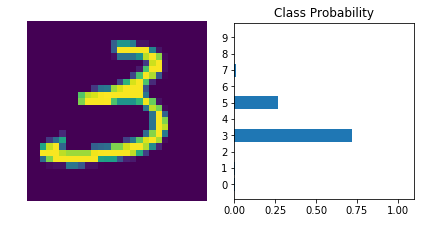

In [34]:
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logits = model.forward(img)

# Output of the network are logits, need to take softmax for probabilities
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)

太棒了！它能够预测出图像中的数字。接下来，我们会学习编写代码，用更复杂的数据集训练神经网络。